## Setup

In [1]:
! pip install neuralogic
from neuralogic.nn import get_evaluator
from neuralogic.core import R, Template, V
from neuralogic.core.settings import Settings
from neuralogic.dataset import Dataset
from neuralogic.optim import SGD
from neuralogic.utils.data import Mutagenesis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 KB 13.9 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/neuralogic/core/builder/builder.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Dataset definition

In [7]:
_, dataset = Mutagenesis()

template = Template()

template.add_rules([
    (R.atom_embed(V.A)[3,] <= R.get(atom)(V.A)) for atom in ["c", "o", "br", "i", "f", "h", "n", "cl"]
])


template.add_rules([
    (R.bond_embed(V.B)[3,] <= R.get(bond)(V.B)) for bond in ["b_1", "b_2", "b_3", "b_4", "b_5", "b_7"]
])


## CW network rules

In [8]:
def bottom_up_features(max_ring_size:int, layer_name: str, node_embed: str, edge_embed: str, connection:str, param_size: tuple):
  template = []
  # atoms aggregate to bonds, bonds to rings
  template += [R.get(layer_name + "_bond_features")(V.B) <= (R.get(connection)(V.X, V.Y, V.B),
                                                             R.get(node_embed)(V.X)[param_size],
                                                             R.get(node_embed)(V.Y)[param_size])]

  # bonds in same cycle
  def get_bond_cycle(n):
      body = [R.get(connection)(f"X{i}", f"X{(i+1) % n}", f"B{i}") for i in range(n)]
      body.extend(R.get(edge_embed)(f"B{i}")[param_size] for i in range(n))
      body.append(R.special.alldiff(...))
      return [R.get(layer_name + "_cycle_features") <= body]


  for i in range(3, max_ring_size):
      template += get_bond_cycle(i)

  template += [R.get(layer_name + "_features") <= (R.get(layer_name + "_bond_features")(V.B)[param_size])]
  template += [R.get(layer_name + "_features") <= (R.get(layer_name + "_cycle_features")[param_size])]
  return template


def top_down_features(max_ring_size:int, layer_name: str, node_embed: str, edge_embed: str, connection:str, param_size: tuple):
  template = []

  def get_cycle_messages(n):
      body = [R.get(connection)(f"X{i}", f"X{(i+1) % n}", f"B{i}") for i in range(n)]
      body.extend(R.get(edge_embed)(f"B{i}")[param_size] for i in range(n))
      body.append(R.special.alldiff(...))

      return [R.get(layer_name + "_cycle_message")(V.B0) <= body]

  for i in range(3, max_ring_size):
      template += get_cycle_messages(i)

  # atoms sharing a bond share messages, bonds in the same ring
  template += [R.get(layer_name + "_atom_nbhood")(V.X) <= (R.get(connection)(V.X, V.Y, V.B),
                                                           R.get(node_embed)(V.Y)[param_size],
                                                           R.get(layer_name + "_bond_nbhood")(V.B)[param_size])]
  template += [R.get(layer_name + "_bond_nbhood")(V.B) <= (R.get(layer_name + "_cycle_message")(V.B)[param_size])] # aggregate messages from all bonds in the same ring

  template += [R.get(layer_name + "_nbhood") <= (R.bond_nbhood(V.B)[param_size])]
  template += [R.get(layer_name + "_nbhood") <= (R.atom_nbhood(V.B)[param_size])]
  return template


def get_cw(max_ring_size:int, layer_name: str, node_embed: str, edge_embed: str, connection:str, param_size: tuple):
  template = []
  template += bottom_up_features(max_ring_size, layer_name, node_embed, edge_embed, connection, param_size)
  template += top_down_features(max_ring_size, layer_name, node_embed, edge_embed, connection, param_size)
  template += [R.get(layer_name) <= (R.get(layer_name + "_nbhood")[param_size])]
  template += [R.get(layer_name) <= (R.get(layer_name + "_features")[param_size])]
  return template


template += get_cw(7, "l1", "atom_embed", "bond_embed", "bond", (3, 3))


In [ ]:
##### CONTROL ######
# atoms aggregate to bonds, bonds to rings
template += R.bond_features(V.B) <= (R.bond(V.X, V.Y, V.B), R.atom_embed(V.X)[3, 3], R.atom_embed(V.Y)[3, 3])

# bonds in same cycle
def get_bond_cycle(n):
    body = [R.bond(f"X{i}", f"X{(i+1) % n}", f"B{i}") for i in range(n)]
    body.extend(R.bond_features(f"B{i}")[3, 3] for i in range(n))
    body.append(R.special.alldiff(...))
    return R.cycle_features <= body


max_ring_size = 7
for i in range(3, max_ring_size):
    template += get_bond_cycle(i)

template += R.features <= (R.bond_features(V.B)[3, 3])
template += R.features <= (R.cycle_features(V.A, V.B)[3, 3])


def get_cycle_messages(n):
    body = [R.bond(f"X{i}", f"X{(i+1) % n}", f"B{i}") for i in range(n)]
    body.extend(R.bond_embed(f"B{i}")[3, 3] for i in range(n))
    body.append(R.special.alldiff(...))

    return R.cycle_message(V.B0) <= body

for i in range(3, max_ring_size):
    template += get_cycle_messages(i)

# atoms sharing a bond share messages, bonds in the same ring
template += R.atom_nbhood(V.X) <= (R.bond(V.X, V.Y, V.B), R.atom_embed(V.Y)[3, 3], R.bond_nbhood(V.B)[3, 3])
template += R.bond_nbhood(V.B) <= (R.cycle_message(V.B)) # aggregate messages from all bonds in the same ring

template += R.nbhood <= (R.bond_nbhood(V.B)[3, 3])
template += R.nbhood <= (R.atom_nbhood(V.B)[3, 3])

In [ ]:
template += R.predict[1, 3] <= (R.nbhood)
template += R.predict[1, 3] <= (R.features)

In [9]:
template += R.predict[1, 3] <= (R.l1)

In [10]:
print(template)

{3} atom_embed(A) :- c(A).
{3} atom_embed(A) :- o(A).
{3} atom_embed(A) :- br(A).
{3} atom_embed(A) :- i(A).
{3} atom_embed(A) :- f(A).
{3} atom_embed(A) :- h(A).
{3} atom_embed(A) :- n(A).
{3} atom_embed(A) :- cl(A).
{3} bond_embed(B) :- b_1(B).
{3} bond_embed(B) :- b_2(B).
{3} bond_embed(B) :- b_3(B).
{3} bond_embed(B) :- b_4(B).
{3} bond_embed(B) :- b_5(B).
{3} bond_embed(B) :- b_7(B).
l1_bond_features(B) :- bond(X, Y, B), {3, 3} atom_embed(X), {3, 3} atom_embed(Y).
l1_cycle_features :- bond(X0, X1, B0), bond(X1, X2, B1), bond(X2, X0, B2), {3, 3} bond_embed(B0), {3, 3} bond_embed(B1), {3, 3} bond_embed(B2), @alldiff(X1, B1, X2, B0, B2, X0).
l1_cycle_features :- bond(X0, X1, B0), bond(X1, X2, B1), bond(X2, X3, B2), bond(X3, X0, B3), {3, 3} bond_embed(B0), {3, 3} bond_embed(B1), {3, 3} bond_embed(B2), {3, 3} bond_embed(B3), @alldiff(B3, X1, B1, X2, B0, B2, X0, X3).
l1_cycle_features :- bond(X0, X1, B0), bond(X1, X2, B1), bond(X2, X3, B2), bond(X3, X4, B3), bond(X4, X0, B4), {3, 3} bon

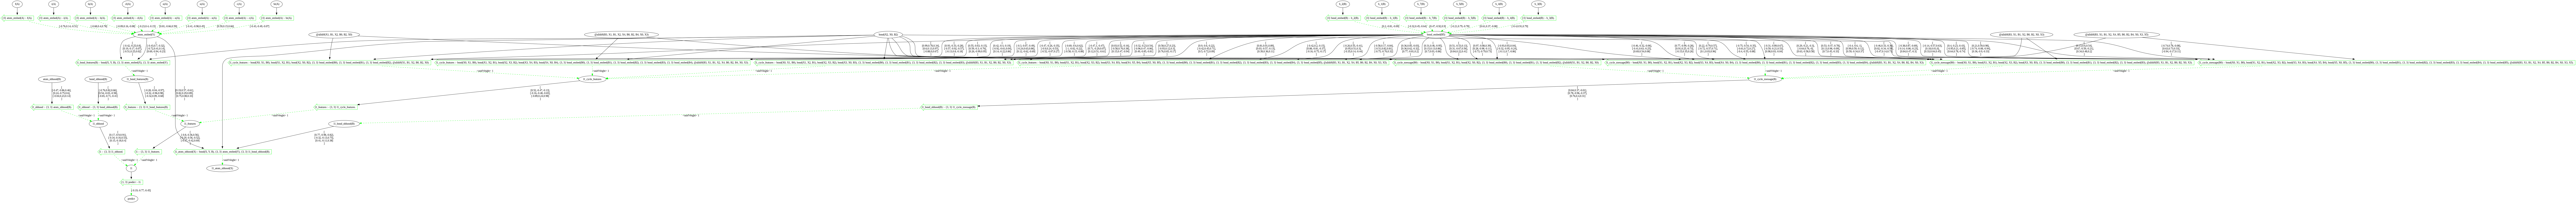

In [11]:
template.draw()

## Training

In [12]:
from neuralogic.core import Settings
from neuralogic.nn.loss import MSE
from neuralogic.nn import get_evaluator
from neuralogic.optim import Adam
import random
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

def train_test_cycle(template, dataset, lr=0.001, epochs=100, split=0.75):
  settings = Settings(optimizer=Adam(lr=lr), epochs=epochs, error_function=MSE())
  evaluator = get_evaluator(template, settings)

  built_dataset = evaluator.build_dataset(dataset)
  dataset_len = len(built_dataset.samples)

  train_size = int(dataset_len*split)

  idx = random.sample(list(range(dataset_len)), train_size)
  rest = list(set(range(dataset_len)) - set(idx))
  train_dataset = np.array(built_dataset.samples)[idx]
  test_dataset = np.array(built_dataset.samples)[rest]
  average_losses = []

  for current_total_loss, number_of_samples in evaluator.train(train_dataset):
      clear_output(wait=True)
      plt.ylabel("Loss")
      plt.xlabel("Epoch")

      plt.xlim(0, settings.epochs)
      
      train_loss = current_total_loss/number_of_samples
      print(train_loss)

      average_losses.append(train_loss)
      
      plt.plot(average_losses, label="Average loss")

      plt.legend()
      plt.pause(0.001)
      plt.show()

  loss = []
  for sample, y_hat in zip(test_dataset, evaluator.test(test_dataset, generator=False)):
      loss.append(round(y_hat) != sample.java_sample.target.value)

  test_loss = sum(loss) / len(test_dataset)

  return train_loss, test_loss, evaluator


0.10079002956071033


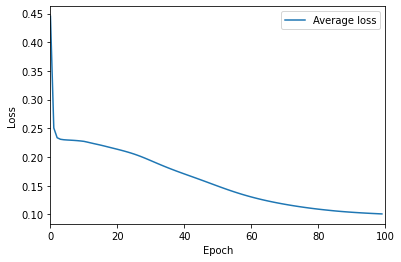

0.1702127659574468

In [13]:
test_losses = []
for i in range(1):
  print("Training and testing model #{}".format(i))
  train_loss, test_loss, eval = train_test_cycle(template, dataset)
  test_losses.append(test_loss)

np.average(test_losses)